Train Accuracy: 0.75
Test Accuracy: 0.5


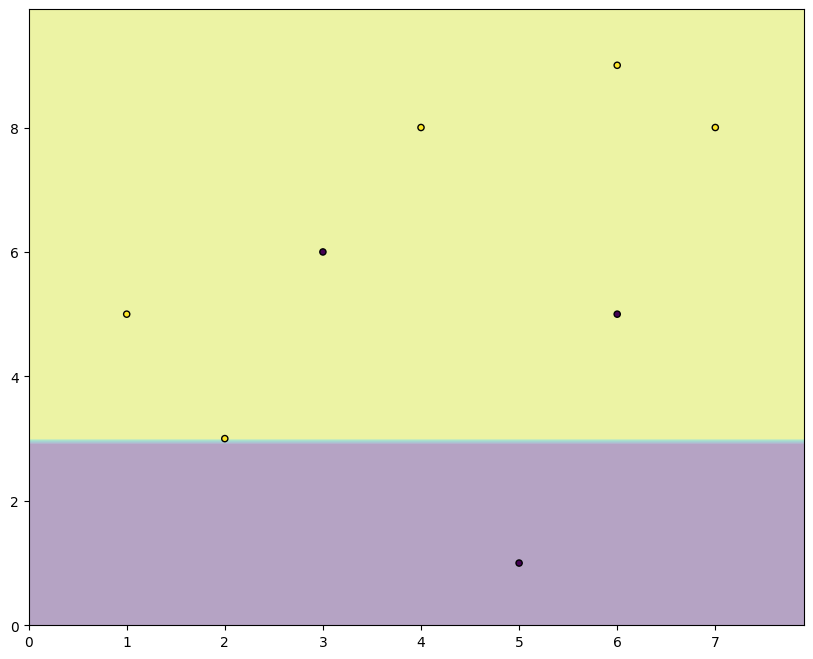

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

class WeakClassifier:
    def __init__(self):
        self.feature_idx = None
        self.threshold = None
        self.alpha = None
        self.prediction = None

def initialize_weights(X):
    m = len(X)
    return np.ones(m) / m

def train_decision_stump(X, y, weights):
    m, n = X.shape
    min_error = float('inf')
    best_stump = None

    for feature_idx in range(n):
        thresholds = np.unique(X[:, feature_idx])
        for threshold in thresholds:
            # Make predictions based on threshold
            prediction = np.where(X[:, feature_idx] < threshold, 0, 1)

            # Compute weighted error
            weighted_error = np.sum(weights * (prediction != y))

            # If error is less than min_error, update best_stump
            if weighted_error < min_error:
                min_error = weighted_error
                best_stump = WeakClassifier()
                best_stump.feature_idx = feature_idx
                best_stump.threshold = threshold
                best_stump.prediction = prediction

    # Compute alpha (classifier weight)
    best_stump.alpha = 0.5 * np.log((1 - min_error) / (min_error + 1e-10))

    return best_stump

def update_weights(weights, alpha, prediction, y):
    factor = np.exp(-alpha * y * prediction)
    return weights * factor / np.sum(weights)

def adaboost(X, y, num_iterations):
    weights = initialize_weights(X)
    classifiers = []
    for _ in range(num_iterations):
        stump = train_decision_stump(X, y, weights)
        error = np.sum(weights * (stump.prediction != y))
        if error == 0:
            break
        stump.alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
        weights = update_weights(weights, stump.alpha, stump.prediction, y)
        classifiers.append(stump)
    return classifiers

def adaboost_predict(classifiers, X):
    predictions = np.zeros(len(X))
    for stump in classifiers:
        prediction = np.where(X[:, stump.feature_idx] < stump.threshold, 0, 1)
        predictions += stump.alpha * prediction
    return np.where(predictions < 0.5, 0, 1)

def plot_decision_boundary(X, y, classifiers):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    f, axarr = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

    Z = adaboost_predict(classifiers, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr.contourf(xx, yy, Z, alpha=0.4)
    axarr.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.show()

def test_adaboost(X_train, y_train, X_test, y_test, num_iterations):
    classifiers = adaboost(X_train, y_train, num_iterations)
    train_accuracy = accuracy_score(y_train, adaboost_predict(classifiers, X_train))
    test_accuracy = accuracy_score(y_test, adaboost_predict(classifiers, X_test))
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    plot_decision_boundary(X_train, y_train, classifiers)

# Dataset
df = pd.DataFrame({
    'X1': [1, 2, 3, 4, 5, 6, 6, 7, 9, 9],
    'X2': [5, 3, 6, 8, 1, 9, 5, 8, 9, 2],
    'label': [1, 1, 0, 1, 0, 1, 0, 1, 0, 0]
})

X = df[['X1', 'X2']].values
y = df['label'].values

# Split dataset into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Test AdaBoost
test_adaboost(X_train, y_train, X_test, y_test, num_iterations=10)



In [ ]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd

def train_weak_learner(df):
    dt = DecisionTreeClassifier(max_depth=1)
    X = df[['X1', 'X2']].values
    y = df['label'].values
    dt.fit(X, y)
    error = 1 - dt.score(X, y)
    alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
    predictions = dt.predict(X)
    df['y_pred'] = predictions
    df['updated_weights'] = df['weights'] * np.exp(-alpha * df['label'] * df['y_pred'])
    return dt, alpha, df

def update_weights(df):
    normalized_weights = df['updated_weights'] / df['updated_weights'].sum()
    df['cumsum_upper'] = np.cumsum(normalized_weights)
    df['cumsum_lower'] = df['cumsum_upper'] - normalized_weights
    return df

def select_instances(df):
    indices = []
    for _ in range(df.shape[0]):
        a = np.random.random()
        for index, row in df.iterrows():
            if row['cumsum_upper'] > a > row['cumsum_lower']:
                indices.append(index)
                break
    return indices

def adaboost(df, num_iterations):
    models = []
    alphas = []
    for _ in range(num_iterations):
        model, alpha, df = train_weak_learner(df)
        models.append(model)
        alphas.append(alpha)
        df = update_weights(df)
        indices = select_instances(df)
        df = df.iloc[indices, :].copy()
    return models, alphas

# Define the dataset
df = pd.DataFrame({
    'X1': [1, 2, 3, 4, 5, 6, 6, 7, 9, 9],
    'X2': [5, 3, 6, 8, 1, 9, 5, 8, 9, 2],
    'label': [1, 1, 0, 1, 0, 1, 0, 1, 0, 0],
    'weights': 1 / 10  # Initialize weights
})

# Train AdaBoost
num_iterations = 3
models, alphas = adaboost(df, num_iterations)

# Output model weights
for i in range(num_iterations):
    print(f"Model {i+1} Weight (alpha{i+1}):", alphas[i])


Model 1 Weight (alpha1): 0.42364893002693504
Model 2 Weight (alpha2): 0.6931471803099455
Model 3 Weight (alpha3): 0.6931471803099455


In [ ]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd

class AdaBoostClassifier:
    def __init__(self, num_iterations):
        self.num_iterations = num_iterations
        self.models = []
        self.alphas = []

    def train_weak_learner(self, df):
        dt = DecisionTreeClassifier(max_depth=1)
        X = df[['X1', 'X2']].values
        y = df['label'].values
        dt.fit(X, y)
        error = 1 - dt.score(X, y)
        alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
        predictions = dt.predict(X)
        df['y_pred'] = predictions
        df['updated_weights'] = df['weights'] * np.exp(-alpha * df['label'] * df['y_pred'])
        return dt, alpha, df

    def update_weights(self, df):
        normalized_weights = df['updated_weights'] / df['updated_weights'].sum()
        df['cumsum_upper'] = np.cumsum(normalized_weights)
        df['cumsum_lower'] = df['cumsum_upper'] - normalized_weights
        return df

    def select_instances(self, df):
        indices = []
        for _ in range(df.shape[0]):
            a = np.random.random()
            for index, row in df.iterrows():
                if row['cumsum_upper'] > a > row['cumsum_lower']:
                    indices.append(index)
                    break
        return indices





In [ ]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd

class AdaBoostClassifier:
    def __init__(self, num_iterations):
        self.num_iterations = num_iterations
        self.models = []
        self.alphas = []

    def train_weak_learner(self, df):
        dt = DecisionTreeClassifier(max_depth=1)
        X = df[['X1', 'X2']].values
        y = df['label'].values
        dt.fit(X, y)
        error = 1 - dt.score(X, y)
        alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
        predictions = dt.predict(X)
        df['y_pred'] = predictions
        df['updated_weights'] = df['weights'] * np.exp(-alpha * df['label'] * df['y_pred'])
        return dt, alpha, df

    def update_weights(self, df):
        normalized_weights = df['updated_weights'] / df['updated_weights'].sum()
        df['cumsum_upper'] = np.cumsum(normalized_weights)
        df['cumsum_lower'] = df['cumsum_upper'] - normalized_weights
        return df

    def select_instances(self, df):
        indices = []
        for _ in range(df.shape[0]):
            a = np.random.random()
            for index, row in df.iterrows():
                if row['cumsum_upper'] > a > row['cumsum_lower']:
                    indices.append(index)
                    break
        return indices

    def fit(self, X, y):
        # Initialize weights
        df = pd.DataFrame({
            'X1': X[:, 0],
            'X2': X[:, 1],
            'label': y,
            'weights': 1 / len(X)
        })

        for _ in range(self.num_iterations):
            model, alpha, df = self.train_weak_learner(df)
            self.models.append(model)
            self.alphas.append(alpha)
            df = self.update_weights(df)
            indices = self.select_instances(df)
            df = df.iloc[indices, :].copy()

    def predict(self, X):
        predictions = np.zeros(len(X))
        for model, alpha in zip(self.models, self.alphas):
            predictions += alpha * model.predict(X)
        return np.sign(predictions)

# Define the dataset
X_train = np.array([[1, 5], [2, 3], [3, 6], [4, 8], [5, 1], [6, 9], [6, 5], [7, 8], [9, 9], [9, 2]])
y_train = np.array([1, 1, 0, 1, 0, 1, 0, 1, 0, 0])

# Train AdaBoost
num_iterations = 3
adaboost = AdaBoostClassifier(num_iterations)
adaboost.fit(X_train, y_train)

# Predict
query = np.array([1, 5]).reshape(1, -1)
print("Predicted Label:", adaboost.predict(query))


Predicted Label: [1.]
